# Pose based Cricket stroke detection

This notebook demonstrates the pose features extracted from the Cricket Highlights Videos dataset. 

In [1]:
import cv2
import numpy as np
import os
import json
import torch
import matplotlib.pyplot as plt

%matplotlib inline

In [41]:
# Set the path of the input videos and the openpose extracted features directory
DATASET = "/opt/datasets/cricket/ICC_WT20"
POSE_FEATS = "/home/arpan/cricket/output_json"
LABELS = "/home/arpan/VisionWorkspace/shot_detection/supporting_files/sample_set_labels/sample_labels_shots/ICC WT20"


In [16]:
all_poses = os.listdir(POSE_FEATS)[:5]    # taking only 5 json files
all_files = sorted(os.listdir(DATASET))
train_vids, val_vids, test_vids = all_files[:16], all_files[16:21], all_files[21:]


In [4]:
all_poses

['ICC WT20 South Africa v Sri Lanka - Match Highlights_000000003380_keypoints.json',
 'ICC WT20 Final - England vs West Indies - Match Highlights_000000002107_keypoints.json',
 'ICC WT20 Sri Lanka v Afghanistan Cricket Match Highlights_000000000965_keypoints.json',
 'ICC WT20 Scotland vs Afghanistan Highlights_000000002271_keypoints.json',
 'ICC WT20 - England v Sri Lanka Match Highlights_000000000120_keypoints.json']

In [5]:
with open(os.path.join(POSE_FEATS, all_poses[0]), 'r') as fp:
    pose_img = json.load(fp)

In [6]:
pose_img

{u'people': [{u'face_keypoints_2d': [],
   u'face_keypoints_3d': [],
   u'hand_left_keypoints_2d': [],
   u'hand_left_keypoints_3d': [],
   u'hand_right_keypoints_2d': [],
   u'hand_right_keypoints_3d': [],
   u'pose_keypoints_2d': [392.738,
    159.929,
    0.538981,
    404.505,
    167.717,
    0.890734,
    411.313,
    162.868,
    0.869837,
    419.21,
    172.647,
    0.76439,
    413.295,
    182.432,
    0.385552,
    399.595,
    168.759,
    0.850759,
    402.548,
    185.417,
    0.832458,
    400.593,
    200.085,
    0.754032,
    413.306,
    197.094,
    0.772627,
    418.237,
    194.186,
    0.811853,
    419.126,
    222.589,
    0.909846,
    426.034,
    244.052,
    0.783685,
    410.326,
    198.087,
    0.811565,
    406.451,
    223.561,
    0.782922,
    405.475,
    248.962,
    0.720332,
    0,
    0,
    0,
    393.737,
    157.014,
    0.540559,
    0,
    0,
    0,
    396.705,
    156.055,
    0.693805,
    402.532,
    252.86,
    0.353035,
    402.52,


In [7]:
len(pose_img['people'])

4

In [9]:
print(all_poses[-1], all_poses[-2])
print(all_poses[0].rsplit('.')[0].rsplit('_', 1)[0])
pose_fname = all_poses[0]
vNameFrame = pose_fname.rsplit('.',1)[0].rsplit('_', 2)   # get a list with 0 index as vName and 1 index as Frame No.
vName = vNameFrame[0]
vFrameNo = vNameFrame[1]
print(vName, int(vFrameNo))

('ICC WT20 - England v Sri Lanka Match Highlights_000000000120_keypoints.json', 'ICC WT20 Scotland vs Afghanistan Highlights_000000002271_keypoints.json')
ICC WT20 South Africa v Sri Lanka - Match Highlights_000000003380
('ICC WT20 South Africa v Sri Lanka - Match Highlights', 3380)


In [10]:
# function to get the image from the video for the corresponding json file
def getImageFromName(pose_fname):
    vNameFrame = pose_fname.rsplit('.',1)[0].rsplit('_', 2)   # get a list with 0 index as vName and 1 index as Frame No.
    vName = vNameFrame[0]+'.avi'
    vFrameNo = int(vNameFrame[1])
    cap = cv2.VideoCapture(os.path.join(DATASET, vName))
    if not cap.isOpened():
        print("Capture object not opened !! Abort !")
        return
    cap.set(cv2.CAP_PROP_POS_FRAMES, vFrameNo)
    ret, img = cap.read()
    if not ret:
        print("Frame not read !!")
        return 
    
    plt.figure()
    plt.imshow(img)
    cap.release()
    return img
        

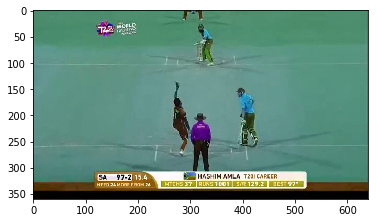

In [11]:
img = getImageFromName(all_poses[0])

In [33]:
def plotPoseKeyPoints(img, pose_kp):
    '''
    img: input image RGB
    pose_kp: dictionary formed by openpose for the corresponding image
    '''
    people = pose_kp['people']
    nPeople = len(people)
    
    for i, p in enumerate(people):
        person_pose_vals = p['pose_keypoints_2d']   # get list of values (x1, y1 ,c1, x2, y2, c2 ...)
        
        for j in range(0, len(person_pose_vals), 3):
            x = int(person_pose_vals[j])
            y = int(person_pose_vals[j+1])
            c = person_pose_vals[j+2]
            #print(x,y,c)
            img[(y-2):(y+2),(x-2):(x+2),:] = 255  # do white
        
        #break  # remove to display for all the persons in the image
        
    #plt.figure()
    #plt.imshow(img)
    return img


In [40]:
#plotPoseKeyPoints(img, pose_img)

In [35]:
img.shape

(360, 640, 3)

In [36]:
def extract_all(srcFolderPath, destFolderPath, onGPU=True, stop='all'):
    """
    Function to extract the features from a list of videos
    
    Parameters:
    ------
    destFolderPath: str
        path to store the optical flow values in .bin files
    onGPU: boolean
        True enables a serial extraction by sending model and data to GPU,
        False enables a parallel extraction on the different CPU cores.
    stop: str
        to traversel 'stop' no of files in each subdirectory.
    
    Returns: 
    ------
    traversed: int
        no of videos traversed successfully
    """
    # iterate over the subfolders in srcFolderPath and extract for each video 
    vfiles = os.listdir(srcFolderPath)
    
    infiles, outfiles, nFrames = [], [], []
    
    traversed = 0
    # create destination path to store the files
    if not os.path.exists(destFolderPath):
        os.makedirs(destFolderPath)
            
    # iterate over the video files inside the directory sf
    for vid in vfiles:
        if os.path.isfile(os.path.join(srcFolderPath, vid)) and vid.rsplit('.', 1)[1] in {'avi', 'mp4'}:
            infiles.append(os.path.join(srcFolderPath, vid))
            outfiles.append(os.path.join(destFolderPath, vid.rsplit('.', 1)[0]+".npy"))
            nFrames.append(getTotalFramesVid(os.path.join(srcFolderPath, vid)))
            # save at the destination, if extracted successfully
            traversed += 1
#            print "Done "+str(traversed_tot+traversed)+" : "+sf+"/"+vid
                    
                # to stop after successful traversal of 2 videos, if stop != 'all'
            if stop != 'all' and traversed == stop:
                break
                    
    print "No. of files to be written to destination : "+str(traversed)
    if traversed == 0:
        print "Check the structure of the dataset folders !!"
        return traversed
    ###########################################################################
    #### Form the pandas Dataframe and parallelize over the files.
    filenames_df = pd.DataFrame({"infiles":infiles, "outfiles": outfiles, "nframes": nFrames})
    filenames_df = filenames_df.sort_values(["nframes"], ascending=[True])
    filenames_df = filenames_df.reset_index(drop=True)
    nrows = filenames_df.shape[0]
    batch = 2  # No. of videos in a single batch
    njobs = 1   # No. of threads
    
    ###########################################################################
    if onGPU:
        # Serial Implementation (For GPU based extraction)
        for i in range(nrows):
            st = time.time()
            feat = getPoseFeats(filenames_df['infiles'][i], onGPU)
            # save the feature to disk
            if feat is not None:
                np.save(filenames_df['outfiles'][i], feat)
                print "Written "+str(i)+" : "+filenames_df['outfiles'][i]
                
            e = time.time()
            print "Execution Time : "+str(e-st)
    
    else:    
        #feat = getC3DFrameFeats(model, filenames_df['infiles'][0], onGPU, depth)
        # Parallel version (For CPU based extraction)
        for i in range(nrows/batch):
            batch_diffs = Parallel(n_jobs=njobs)(delayed(getPoseFeats) \
                        (filenames_df['infiles'][i*batch+j], onGPU) \
                        for j in range(batch))
            print "i = "+str(i)
            # Writing the diffs in a serial manner
            for j in range(batch):
                if batch_diffs[j] is not None:
                    np.save(filenames_df['outfiles'][i*batch+j], batch_diffs[j])
                    print "Written "+str(i*batch+j+1)+" : "+ \
                                filenames_df['outfiles'][i*batch+j]
                
        # For last batch which may not be complete, extract serially
        last_batch_size = nrows - ((nrows/batch)*batch)
        if last_batch_size > 0:
            batch_diffs = Parallel(n_jobs=njobs)(delayed(getPoseFeats) \
                        (filenames_df['infiles'][(nrows/batch)*batch+j], onGPU) \
                        for j in range(last_batch_size)) 
            # Writing the diffs in a serial manner
            for j in range(last_batch_size):
                if batch_diffs[j] is not None:
                    np.save(filenames_df['outfiles'][(nrows/batch)*batch+j], batch_diffs[j])
                    print "Written "+str((nrows/batch)*batch+j+1)+" : "+ \
                                filenames_df['outfiles'][(nrows/batch)*batch+j]
    
    ###########################################################################
#    print len(batch_diffs)
    return traversed


def getTotalFramesVid(srcVideoPath):
    """
    Return the total number of frames in the video
    
    Parameters:
    ------
    srcVideoPath: str
        complete path of the source input video file
        
    Returns:
    ------
    total frames present in the given video file
    """
    cap = cv2.VideoCapture(srcVideoPath)
    # if the videoCapture object is not opened then exit without traceback
    if not cap.isOpened():
        print("Error reading the video file !!")
        return 0

    tot_frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    cap.release()
    return tot_frames    

In [38]:
def getPoseFeats(videoName, onGPU):
    """
    Function to read all the frames of the video and get sequence of features
     one batch at a time. 
    This function can be called parallely called based on the amount of 
    memory available.
    
    Parameters:
    ------
    videoName: str
        file name of the video.
        
    Returns:
    ------
    np.array of size (N-depth+1) x 4096 (N is the no. of frames in video.)
    """
    
    # get the VideoCapture object
    cap = cv2.VideoCapture(os.path.join(DATASET, videoName))
    prefix = videoName.rsplit('.', 1)[0]
    
    # if the videoCapture object is not opened then exit without traceback
    if not cap.isOpened():
        print("Error reading the video file !!")
        return None
    
    W, H = (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
    totalFrames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    frameCount = 0
    features_current_file = []
    
    #ret, prev_frame = cap.read()
    assert cap.isOpened(), "Capture object does not return a frame!"
    #prev_frame = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
    X = []  # input, initially a list, after first 16 frames converted to ndarray
    # Iterate over the entire video to get the optical flow features.
    while(cap.isOpened()):
        
        ret, curr_frame = cap.read()    # H x W x C
        if not ret:
            break
        poseFile = os.path.join(POSE_FEATS, prefix+'_{:012}'.format(frameCount)+'_keypoints.json')
        if not os.path.exists(poseFile):
            print("File does not exist !! {}".format(frameCount))
            frameCount +=1
            continue
            
        # resize to 180 X 320 and taking centre crop of 112 x 112
        #curr_frame = cv2.resize(curr_frame, (W/2, H/2), cv2.INTER_AREA)
        #(h, w) = curr_frame.shape[:2]
        # size is 112 x 112 x 3
        #curr_frame = curr_frame[(h/2-56):(h/2+56), (w/2-56):(w/2+56), :]
        with open(poseFile, 'r') as fp:
            pose_dict = json.load(fp)
        curr_frame = plotPoseKeyPoints(curr_frame, pose_dict)
        #print(type(curr_frame), curr_frame.shape)
        
        if frameCount % 100 == 0:
            plt.figure()
            plt.imshow(curr_frame)
        
        frameCount +=1
        #print "{} / {}".format(frameCount, totalFrames)

    # When everything done, release the capture
    cap.release()
    #return features_current_file
    #return np.array(features_current_file)      # convert to (N-depth+1) x 1 x 4096


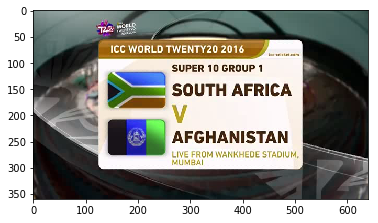

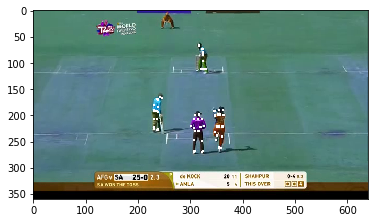

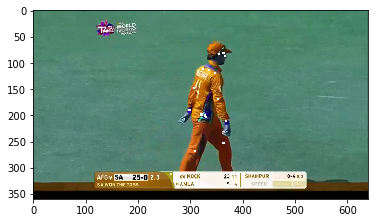

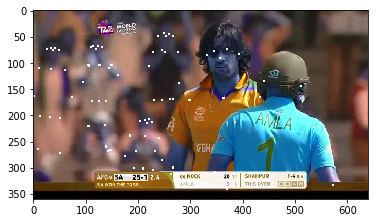

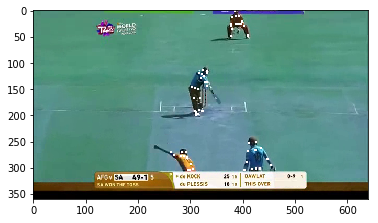

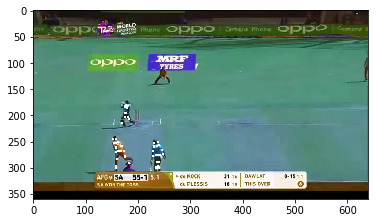

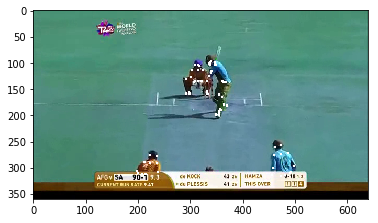

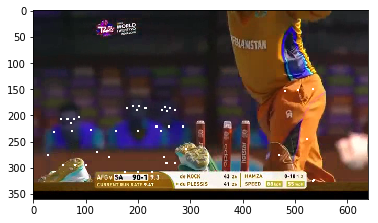

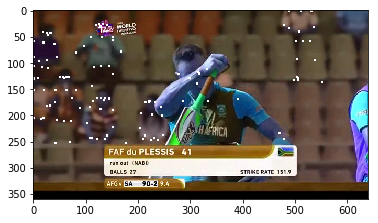

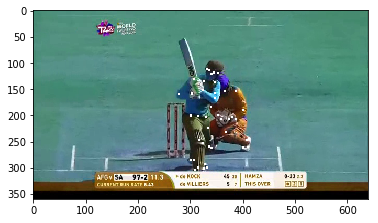

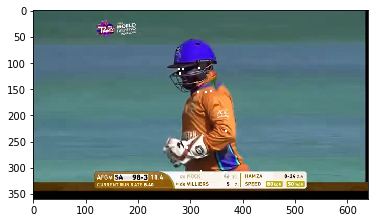

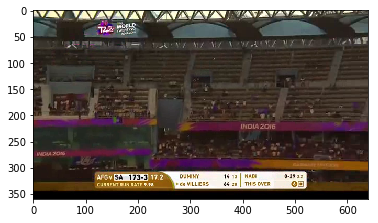

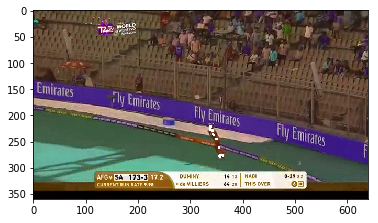

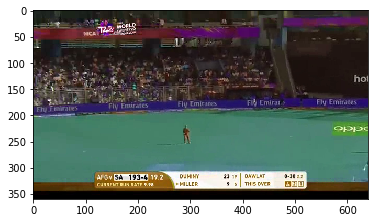

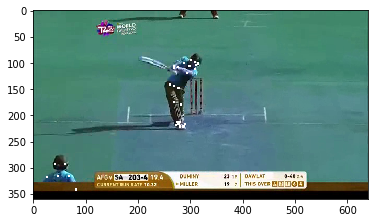

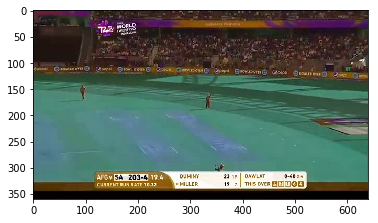

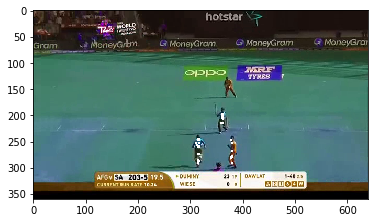

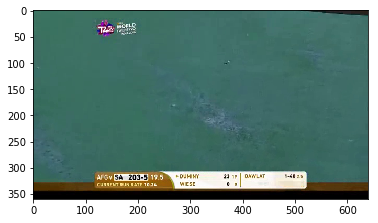

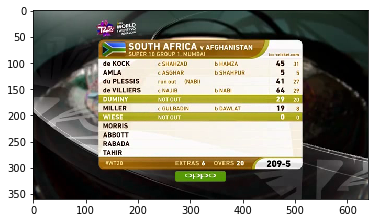

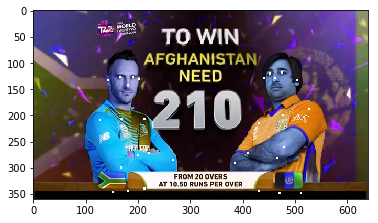

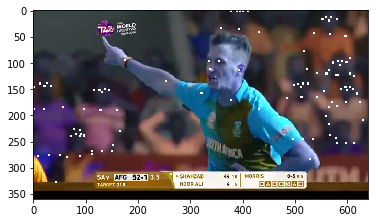

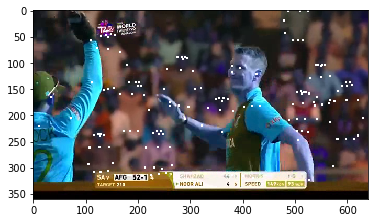

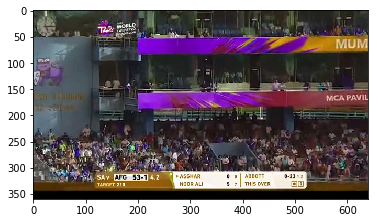

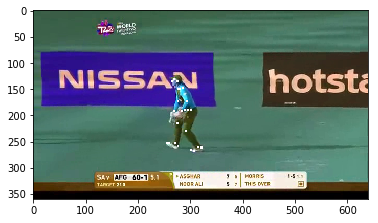

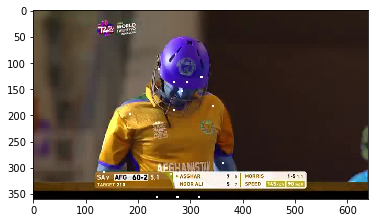

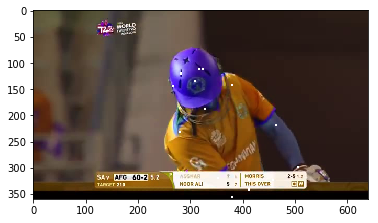

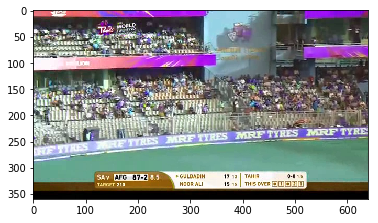

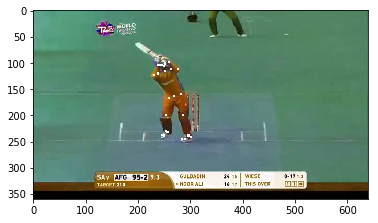

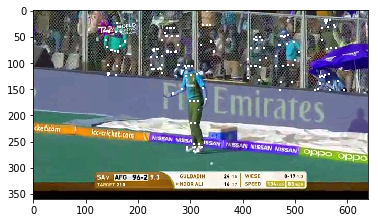

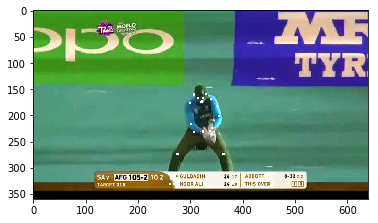

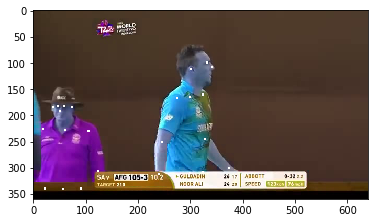

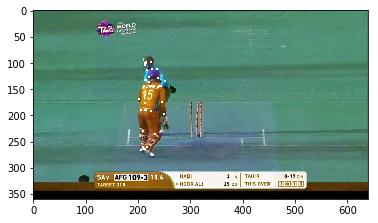

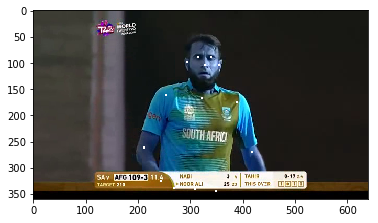

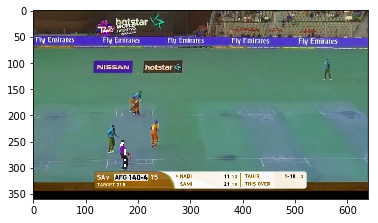

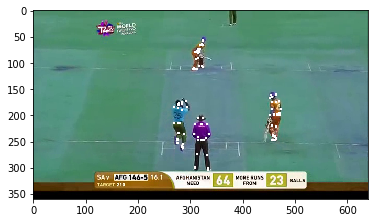

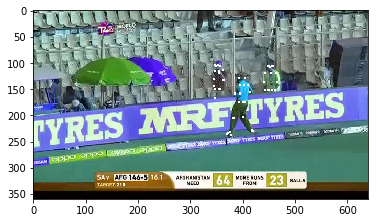

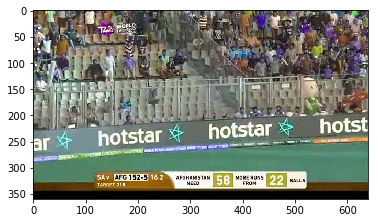

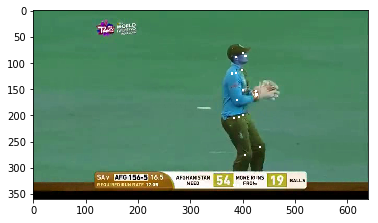

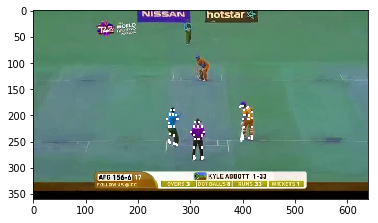

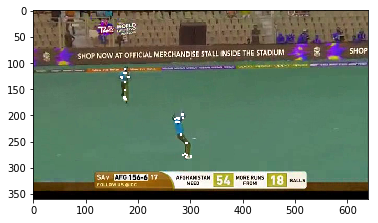

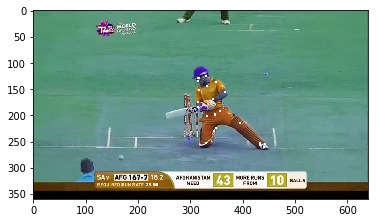

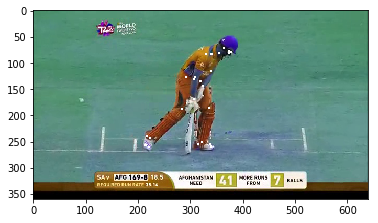

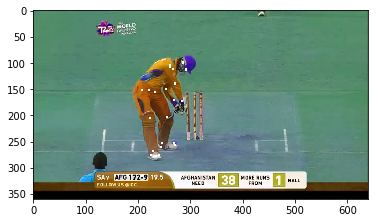

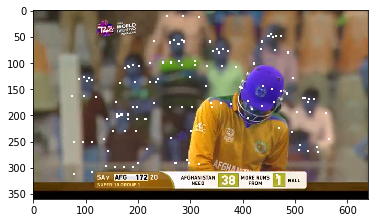

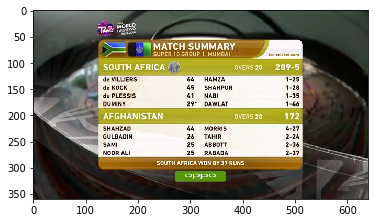

In [39]:
getPoseFeats(train_vids[0], False)

In [28]:
train_vids[0]

'ICC WT20 - Afghanistan vs South Africa - Match Highlights.avi'

In [52]:
#trackPoints()
# Learn from the tracked points
pose_img['people'][0]['pose_keypoints_2d']

[392.738,
 159.929,
 0.538981,
 404.505,
 167.717,
 0.890734,
 411.313,
 162.868,
 0.869837,
 419.21,
 172.647,
 0.76439,
 413.295,
 182.432,
 0.385552,
 399.595,
 168.759,
 0.850759,
 402.548,
 185.417,
 0.832458,
 400.593,
 200.085,
 0.754032,
 413.306,
 197.094,
 0.772627,
 418.237,
 194.186,
 0.811853,
 419.126,
 222.589,
 0.909846,
 426.034,
 244.052,
 0.783685,
 410.326,
 198.087,
 0.811565,
 406.451,
 223.561,
 0.782922,
 405.475,
 248.962,
 0.720332,
 0,
 0,
 0,
 393.737,
 157.014,
 0.540559,
 0,
 0,
 0,
 396.705,
 156.055,
 0.693805,
 402.532,
 252.86,
 0.353035,
 402.52,
 253.827,
 0.482938,
 408.414,
 253.835,
 0.666684,
 422.108,
 253.863,
 0.540277,
 426.026,
 253.809,
 0.517997,
 427.007,
 246.974,
 0.755952]